In [1]:
!pip install scienceplots

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import re
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import requests
import math
import os
import scienceplots

from sklearn.preprocessing import StandardScaler

In [3]:
plt.style.use(["science","notebook","grid"])

In [4]:
# Configuraciones
url = "https://ssd-api.jpl.nasa.gov/cad.api"
params_base = {
    "date-min": "1900-01-01",
    "date-max": "2100-01-01",
    "dist-max": "10",  # 10 AU cubre mucho más
    "limit": 100000,
    "fullname": "true"
}

all_data = []
start = 1
while True:
    params = params_base.copy()
    params["limit-from"] = start
    response = requests.get(url, params=params)
    dataapi = response.json()

    # Extraer registros
    rows = dataapi.get('data', [])
    if not rows:
        break  # No hay más registros

    all_data.extend(rows)
    print(f"{len(all_data)} registros descargados...")

    if len(rows) < 100000:
        break  # Ya no quedan más

    start += 100000

# Convertir todo en DataFrame
columns = dataapi['fields']
dfapi = pd.DataFrame(all_data, columns=columns)

# # Guardar CSV
# dfapi.to_csv("asteroid_all_approaches.csv", index=False)

100000 registros descargados...
200000 registros descargados...
300000 registros descargados...
400000 registros descargados...
500000 registros descargados...
538662 registros descargados...


In [5]:
fecha_hoy = datetime.utcnow().strftime('%Y-%m-%d')  # fecha actual en formato AAAA-MM-DD (UTC)
url = f"https://ssd-api.jpl.nasa.gov/cad.api?date-min=1900-01-01&date-max={fecha_hoy}&dist-max=0.05"

respuesta = requests.get(url)
if respuesta.status_code != 200:
    raise Exception(f"Error al obtener datos de la API: {respuesta.status_code}")

datos_json = respuesta.json()

columnas = datos_json.get('fields', [])
datos = datos_json.get('data', [])
df = pd.DataFrame(data=datos, columns=columnas)

columnas_relevantes = ["des", "cd", "dist", "dist_min", "v_rel", "v_inf", "h"]
df = df[columnas_relevantes].copy()

df["dist"] = pd.to_numeric(df["dist"], errors='coerce')
df["dist_min"] = pd.to_numeric(df["dist_min"], errors='coerce')
df["v_rel"] = pd.to_numeric(df["v_rel"], errors='coerce')
df["v_inf"] = pd.to_numeric(df["v_inf"], errors='coerce')
df["h"] = pd.to_numeric(df["h"], errors='coerce')

factor_albedo = 1329 / math.sqrt(0.14)
df["diameter"] = factor_albedo * (10 ** (-0.2 * df["h"]))

def clasificar_rareza(fila):
    dist = fila["dist"]
    diam = fila["diameter"]
    if dist < 0.001:
        dist_cat = 4
    elif dist < 0.005:
        dist_cat = 3
    elif dist < 0.01:
        dist_cat = 2
    elif dist < 0.02:
        dist_cat = 1
    else:
        dist_cat = 0
    if diam >= 1:  # >= 1 km (objeto muy grande)
        size_cat = 4
    elif diam >= 0.14:  # >= 0.14 km (~140 m)
        size_cat = 3
    elif diam >= 0.05:   # >= 0.05 km (~50 m)
        size_cat = 2
    elif diam >= 0.01:   # >= 0.01 km (~10 m)
        size_cat = 1
    else:
        size_cat = 0
    if size_cat <= 1:
        rareza = 1 if dist_cat >= 1 else 0
    else:
        if size_cat >= 3 and dist_cat >= 3:
            rareza = 4  # tamaño y distancia muy significativos -> muy raro
        elif size_cat >= 4 or dist_cat >= 4:
            rareza = 4  # cualquiera de los dos factores en extremo -> muy raro
        elif size_cat == 2 and dist_cat >= 4:
            rareza = 3  # objeto mediano extremadamente cerca -> raro
        elif size_cat >= 3 and dist_cat == 2:
            rareza = 3  # objeto grande a distancia moderada -> raro
        elif size_cat == 2 and dist_cat == 3:
            rareza = 2  # objeto mediano muy cerca -> infrecuente
        else:
            rareza = max(size_cat, dist_cat)
            if rareza > 4:
                rareza = 4
    return rareza

df["rareza"] = df.apply(clasificar_rareza, axis=1)

df = df.rename(columns={
    "des": "Object",
    "cd": "Close-Approach (CA) Date",
    "dist": "CA DistanceNominal (au)",
    "dist_min": "CA DistanceMinimum (au)",
    "v_rel": "V relative(km/s)",
    "v_inf": "V infinity(km/s)",
    "h": "H(mag)",
    "diameter": "Diameter",
    "rareza": "Rarity"
})

ruta_csv = "/content/close_approaches.csv"
df.to_csv(ruta_csv, index=False)
print(f"Archivo CSV guardado en {ruta_csv} con {len(df)} registros de acercamientos cercanos.")

/tmp/ipython-input-2885795060.py:1: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  fecha_hoy = datetime.utcnow().strftime('%Y-%m-%d')  # fecha actual en formato AAAA-MM-DD (UTC)


Archivo CSV guardado en /content/close_approaches.csv con 31352 registros de acercamientos cercanos.


In [6]:
# dfapi

In [7]:
Ne= pd.read_csv('/content/close_approaches.csv')
Ne

# Contenido:

# Object: Nombre del NEO
# Close-Approach (CA) Date: Fecha de el momento en que el NEO paso mas cerca de la tierra
# CA DistanceNominal(au):  Es la distancia promedio entre el asteroide y la Tierra
# CA DistanceMinimum (au): Es la menor distancia posible a la que el asteroide podría pasar. Se usa cuando hay un poco de duda en la trayectoria exacta.
# V relative(km/s): Es la velocidad del asteroide cuando pasa cerca de la Tierra. Se mide en kilómetros por segundo.
# V infinity(km/s): Es la velocidad del asteroide cuando está lejos de la Tierra, sin la influencia de nuestra gravedad.
# H(mag): Es el brillo del asteroide. Un número más bajo significa que el asteroide es más brillante y probablemente más grande.
# Diameter: Es la medida del diametro del asteroide
# Rarity: La variable Rarity indica la rareza de un evento de aproximación cercana de un objeto a la Tierra, clasificada en una escala de 0 a 4.
# dist_cat = 4 (muy cercano)
# dist_cat = 3
# dist_cat = 2
# dist_cat = 1
# dist_cat = 0 (la más lejana dentro de "cercano")


,Object,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity
0,509352,1900-Jan-04 22:25,0.009632,0.009625,8.686710,8.654806,20.160,0.329960,3
1,2014 SC324,1900-Jan-11 01:07,0.039964,0.039904,10.652382,10.646122,24.390,0.047039,0
2,2012 UK171,1900-Jan-12 23:02,0.049706,0.049578,7.153496,7.145999,24.460,0.045547,0
3,2024 BA5,1900-Jan-25 06:22,0.026434,0.011310,8.436204,8.424247,26.020,0.022206,0
4,2024 BW1,1900-Jan-25 19:29,0.037979,0.010125,6.339787,6.328711,25.120,0.033609,0
...,...,...,...,...,...,...,...,...,...
31347,2026 CV,2026-Feb-12 13:18,0.035231,0.034968,10.347992,10.340681,25.904,0.023424,0
31348,2022 DV,2026-Feb-12 23:08,0.039493,0.026072,5.004609,4.991110,26.530,0.017557,0
31349,2026 CT1,2026-Feb-12 23:46,0.028662,0.028500,7.043262,7.030051,26.113,0.021275,0
31350,2026 CA1,2026-Feb-13 06:55,0.016316,0.016286,8.350807,8.331229,25.618,0.026722,1


In [8]:
Ne.isna().sum()

,0
Object,0
Close-Approach (CA) Date,0
CA DistanceNominal (au),0
CA DistanceMinimum (au),0
V relative(km/s),0
V infinity(km/s),18
H(mag),8
Diameter,8
Rarity,0


In [9]:
#def procesar_diametro(diametro):

 #    diametro = diametro.strip().lower()

  #   en_kilometros = 'km' in diametro

   #  diametro = re.sub(r'[^\d.\s-]', '', diametro)

    # valores = re.findall(r'(\d+\.?\d*)', diametro)

     #if len(valores) == 2:
        # min_valor, max_valor = map(float, valores)
       #  promedio = (min_valor + max_valor) / 2
     #elif len(valores) == 1:
         #promedio = float(valores[0])
     #else:
      #   return None

     #if en_kilometros:
      #   promedio *= 1000

     #return promedio

 #Ne['Diameter'] = Ne['Diameter'].apply(procesar_diametro)
 #Ne

In [10]:
def limpiar_fecha(fecha):
    fecha_limpia = re.sub(r'\s±.*', '', fecha)
    fecha_limpia = re.sub(r'[()]', '', fecha_limpia).strip()
    try:
        return datetime.strptime(fecha_limpia, '%Y-%b-%d %H:%M')
    except ValueError:
        return None


Ne['Close-Approach (CA) Date'] = Ne['Close-Approach (CA) Date'].apply(limpiar_fecha)

Ne


,Object,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity
0,509352,1900-01-04 22:25:00,0.009632,0.009625,8.686710,8.654806,20.160,0.329960,3
1,2014 SC324,1900-01-11 01:07:00,0.039964,0.039904,10.652382,10.646122,24.390,0.047039,0
2,2012 UK171,1900-01-12 23:02:00,0.049706,0.049578,7.153496,7.145999,24.460,0.045547,0
3,2024 BA5,1900-01-25 06:22:00,0.026434,0.011310,8.436204,8.424247,26.020,0.022206,0
4,2024 BW1,1900-01-25 19:29:00,0.037979,0.010125,6.339787,6.328711,25.120,0.033609,0
...,...,...,...,...,...,...,...,...,...
31347,2026 CV,2026-02-12 13:18:00,0.035231,0.034968,10.347992,10.340681,25.904,0.023424,0
31348,2022 DV,2026-02-12 23:08:00,0.039493,0.026072,5.004609,4.991110,26.530,0.017557,0
31349,2026 CT1,2026-02-12 23:46:00,0.028662,0.028500,7.043262,7.030051,26.113,0.021275,0
31350,2026 CA1,2026-02-13 06:55:00,0.016316,0.016286,8.350807,8.331229,25.618,0.026722,1


In [11]:
def velocidad_escape():
    G = 6.67430e-11  # Constante gravitacional en m^3 / (kg·s^2)
    masa_tierra = 5.972e24       # kg

    radio_tierra = 6.371e6
    v_escape = (math.sqrt((2 * G * masa_tierra) / radio_tierra))/1000
    return v_escape


In [12]:


# Velocidad de escape (km/s)
v_esc = velocidad_escape()

# Máscara: valores nulos en 'V infinity(km/s)'
mask_nan = Ne['V infinity(km/s)'].isna()

# Máscara: nulos que cumplen con la condición física
mask_valid = mask_nan & ((Ne['V relative(km/s)']**2 - v_esc**2) >= 0)

# Imputar con la fórmula física
Ne.loc[mask_valid, 'V infinity(km/s)'] = np.sqrt(
    Ne.loc[mask_valid, 'V relative(km/s)']**2 - v_esc**2
)

# Imputar con la media para los que no cumplen la condición física
mask_invalid = mask_nan & ((Ne['V relative(km/s)']**2 - v_esc**2) < 0)
Ne.loc[mask_invalid, 'V infinity(km/s)'] = Ne['V infinity(km/s)'].mean()




In [13]:
Ne.isna().sum()

,0
Object,0
Close-Approach (CA) Date,0
CA DistanceNominal (au),0
CA DistanceMinimum (au),0
V relative(km/s),0
V infinity(km/s),0
H(mag),8
Diameter,8
Rarity,0


In [14]:
Ne.dropna(subset=['H(mag)', 'Diameter'], inplace=True)

Ne.isna().sum()

,0
Object,0
Close-Approach (CA) Date,0
CA DistanceNominal (au),0
CA DistanceMinimum (au),0
V relative(km/s),0
V infinity(km/s),0
H(mag),0
Diameter,0
Rarity,0


In [15]:
data = Ne.sort_values(by='Close-Approach (CA) Date', ascending=False)
data

,Object,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity
31351,2026 CK2,2026-02-13 14:24:00,0.026403,0.026129,5.305884,5.286830,25.705,0.025672,0
31350,2026 CA1,2026-02-13 06:55:00,0.016316,0.016286,8.350807,8.331229,25.618,0.026722,1
31349,2026 CT1,2026-02-12 23:46:00,0.028662,0.028500,7.043262,7.030051,26.113,0.021275,0
31348,2022 DV,2026-02-12 23:08:00,0.039493,0.026072,5.004609,4.991110,26.530,0.017557,0
31347,2026 CV,2026-02-12 13:18:00,0.035231,0.034968,10.347992,10.340681,25.904,0.023424,0
...,...,...,...,...,...,...,...,...,...
4,2024 BW1,1900-01-25 19:29:00,0.037979,0.010125,6.339787,6.328711,25.120,0.033609,0
3,2024 BA5,1900-01-25 06:22:00,0.026434,0.011310,8.436204,8.424247,26.020,0.022206,0
2,2012 UK171,1900-01-12 23:02:00,0.049706,0.049578,7.153496,7.145999,24.460,0.045547,0
1,2014 SC324,1900-01-11 01:07:00,0.039964,0.039904,10.652382,10.646122,24.390,0.047039,0


In [16]:
X = data[["CA DistanceNominal (au)","CA DistanceMinimum (au)", "V relative(km/s)", "V infinity(km/s)","H(mag)", "Diameter","Rarity"]]

scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=42)
data["Cluster"] = kmeans.fit_predict(Xscaled)
print(data[["Object", "Cluster"]].head())

         Object  Cluster
31351  2026 CK2        1
31350  2026 CA1        0
31349  2026 CT1        1
31348   2022 DV        1
31347   2026 CV        1


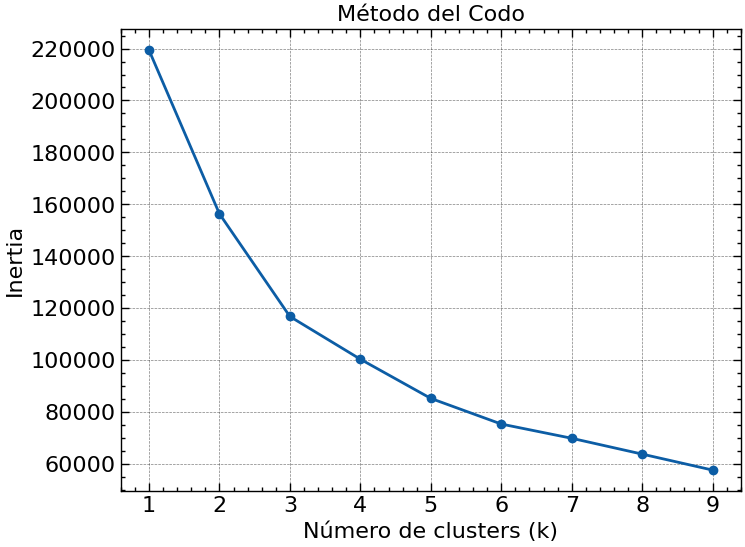

In [17]:

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Xscaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.title('Método del Codo')
plt.show()

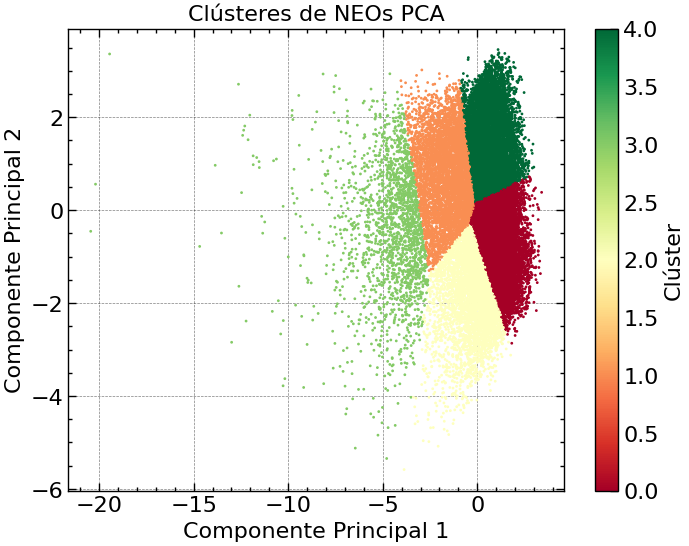

In [18]:
Xax = pd.DataFrame(Xscaled)

pca = PCA(n_components=2)
pcaresult = pca.fit_transform(Xax)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(pcaresult)
data_numerica = Xax.copy()
data_numerica['PCA1'] = pcaresult[:, 0]
data_numerica['PCA2'] = pcaresult[:, 1]
data_numerica['Cluster'] = clusters

plt.figure(figsize=(8, 6))
plt.scatter(data_numerica['PCA1'], data_numerica['PCA2'], c=data_numerica['Cluster'], cmap='RdYlGn', s=1)
plt.title('Clústeres de NEOs PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Clúster')
plt.grid(True)
plt.show()


In [19]:
# Agrupar los datos originales por la columna 'Cluster' (obtenida mediante K-Means aplicado sobre PCA)
# y mostrar las estadísticas descriptivas (media, desviación estándar, mín, máx, cuartiles)
# para cada cluster identificado
for cluster_id in sorted(data['Cluster'].unique()):
    print(f"Descripción del Cluster {cluster_id}:")
    display(data[data['Cluster'] == cluster_id].describe())
    print("\n" + "="*50 + "\n")

Cluster 0 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster
count,9464,9464.000000,9464.000000,9464.000000,9464.000000,9464.000000,9464.000000,9464.000000,9464.0
mean,2003-06-15 19:07:58.801775104,0.010891,0.008816,8.139876,8.062505,27.013394,0.018382,0.982460,0.0
min,1900-02-04 06:16:00,0.000044,0.000000,0.609852,0.216022,22.010000,0.000553,0.000000,0.0
25%,1997-05-27 22:36:45,0.005198,0.003750,6.106364,6.044138,26.010000,0.008922,1.000000,0.0
50%,2018-02-15 09:00:00,0.010547,0.008309,8.207031,8.149556,27.000000,0.014140,1.000000,0.0
75%,2022-09-11 01:29:30,0.015860,0.013535,10.260448,10.203164,28.000000,0.022308,1.000000,0.0
max,2026-02-13 06:55:00,0.040156,0.023381,16.688109,14.833176,34.037000,0.140754,4.000000,0.0
std,NaN,0.006804,0.005693,2.803914,2.805274,1.604243,0.015312,0.328808,0.0




Cluster 1 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster
count,11171,11171.000000,11171.000000,11171.000000,11171.000000,11171.000000,11171.000000,11171.0,11171.0
mean,1992-08-22 03:41:02.980932736,0.035415,0.031099,7.779264,7.767141,26.099451,0.024462,0.0,1.0
min,1900-01-11 01:07:00,0.020009,0.000056,0.275869,0.125474,24.260000,0.000913,0.0,1.0
25%,1967-08-01 10:49:00,0.028207,0.023897,5.470046,5.455137,25.200000,0.015505,0.0,1.0
50%,2011-02-23 15:29:00,0.035575,0.031049,7.597076,7.587900,25.910000,0.023359,0.0,1.0
75%,2021-02-09 17:59:30,0.042652,0.039092,9.887156,9.879142,26.800000,0.032394,0.0,1.0
max,2026-02-13 14:24:00,0.049996,0.049991,18.370334,18.367334,32.950000,0.049941,0.0,1.0
std,NaN,0.008452,0.010197,3.104652,3.110724,1.220441,0.011391,0.0,0.0




Cluster 2 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster
count,4508,4508.000000,4508.000000,4508.000000,4508.000000,4508.000000,4508.000000,4508.000000,4508.0
mean,2004-08-08 23:27:01.996450688,0.017990,0.014466,17.377798,17.348230,25.775154,0.032133,0.825200,2.0
min,1900-02-24 12:01:00,0.000045,0.000005,11.541242,11.531669,21.160000,0.001068,0.000000,2.0
25%,2005-08-20 05:24:30,0.008004,0.005679,14.454545,14.428471,24.710000,0.016235,0.000000,2.0
50%,2018-09-09 07:38:30,0.016677,0.012774,16.414021,16.384918,25.650000,0.026331,1.000000,2.0
75%,2022-10-20 04:59:30,0.026097,0.021007,19.302131,19.267602,26.700000,0.040594,1.000000,2.0
max,2026-02-12 10:58:00,0.049838,0.049696,40.190937,40.186533,32.610000,0.208191,4.000000,2.0
std,NaN,0.011921,0.010643,3.980629,3.979234,1.625425,0.024496,0.679056,0.0




Cluster 3 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster
count,1207,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.0
mean,1965-09-27 16:26:49.262634736,0.033335,0.032753,19.825210,19.818994,19.478190,0.573471,3.102734,3.0
min,1900-01-29 18:09:00,0.000503,0.000499,5.408461,5.390654,14.080000,0.101499,2.000000,3.0
25%,1933-08-23 06:55:30,0.025036,0.024239,14.881952,14.877680,18.590000,0.284748,3.000000,3.0
50%,1965-09-15 19:13:00,0.035386,0.034823,19.645914,19.639469,19.620000,0.423117,3.000000,3.0
75%,1999-02-19 14:29:00,0.043359,0.042891,24.174020,24.171368,20.480000,0.679925,3.000000,3.0
max,2025-12-15 21:29:00,0.049991,0.049959,40.672808,40.670955,22.720000,5.425765,4.000000,3.0
std,NaN,0.011766,0.012033,6.680483,6.682603,1.423338,0.501789,0.356486,0.0




Cluster 4 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster
count,4994,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.0
mean,1977-05-07 11:08:30.624749696,0.035609,0.034101,11.344777,11.336039,22.605677,0.127741,2.313777,4.0
min,1900-01-04 22:25:00,0.000803,0.000148,1.581997,1.547734,18.970000,0.050172,2.000000,4.0
25%,1942-02-08 02:00:00,0.028986,0.026984,8.367597,8.357457,21.720000,0.064634,2.000000,4.0
50%,1986-03-25 00:01:30,0.036854,0.035480,10.968795,10.960742,22.820000,0.096931,2.000000,4.0
75%,2014-06-10 14:23:00,0.043707,0.042686,14.002833,13.998276,23.700000,0.160865,3.000000,4.0
max,2026-02-05 00:25:00,0.050000,0.049999,25.851252,25.849130,24.250000,0.570770,4.000000,4.0
std,NaN,0.009746,0.010499,4.010118,4.013365,1.235259,0.086326,0.468369,0.0


In [38]:
# Crear carpeta para guardar gráficas
output_dir = "pairplots_cluster"
os.makedirs(output_dir, exist_ok=True)

# Obtener clusters únicos
clusters = sorted(data['Cluster'].unique())
print(f"Total de clusters encontrados: {len(clusters)}")
print(f"Clusters: {clusters}\n")

for cluster_id in clusters:
    print(f"Generando pair plot para Cluster {cluster_id}...")

    # Filtrar datos por cluster
    cluster_data = data[data['Cluster'] == cluster_id].copy()
    print(f"  Muestras en este cluster: {len(cluster_data)}")

    # Crear pairplot
    g = sns.pairplot(
        data=cluster_data,
        plot_kws={'alpha': 0.6, 's': 15},
        diag_kws={'bins': 25},
        height=2,
        aspect=1
    )

    g.fig.suptitle(f'Pair Plot - Cluster {cluster_id}',
                   y=1.00, fontsize=12, fontweight='bold')

    # Ajustar tamaños
    for ax in g.axes.flatten():
        ax.tick_params(labelsize=7)
        ax.xaxis.label.set_size(8)
        ax.yaxis.label.set_size(8)

    plt.tight_layout()

    # Guardar en alta resolución
    filename = f"{output_dir}/cluster_{cluster_id}_pairplot.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f" Guardado: {filename}")

    plt.close()  # Cerrar para liberar memoria
    print("="*60 + "\n")

print(f" Todas las gráficas guardadas en '{output_dir}/'")
print(f" Total de archivos generados: {len(clusters)}")

Total de clusters encontrados: 5
Clusters: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4)]

Generando pair plot para Cluster 0...
  Muestras en este cluster: 9464
  ✓ Guardado: pairplots_cluster/cluster_0_pairplot.png

Generando pair plot para Cluster 1...
  Muestras en este cluster: 11171
  ✓ Guardado: pairplots_cluster/cluster_1_pairplot.png

Generando pair plot para Cluster 2...
  Muestras en este cluster: 4508
  ✓ Guardado: pairplots_cluster/cluster_2_pairplot.png

Generando pair plot para Cluster 3...
  Muestras en este cluster: 1207
  ✓ Guardado: pairplots_cluster/cluster_3_pairplot.png

Generando pair plot para Cluster 4...
  Muestras en este cluster: 4994
  ✓ Guardado: pairplots_cluster/cluster_4_pairplot.png

✓ Todas las gráficas guardadas en 'pairplots_cluster/'
✓ Total de archivos generados: 5


### **APLICAR K-MINS PRECOMPUTADO**

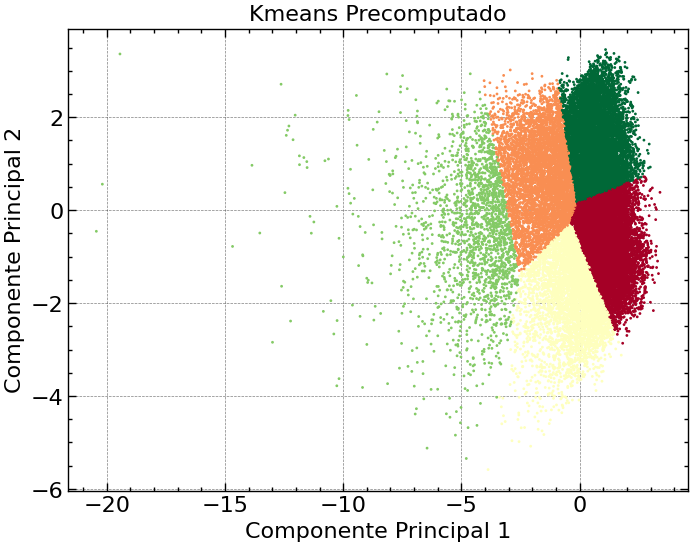

In [21]:
pca = PCA(n_components=2)
pcaresult = pca.fit_transform(Xscaled)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(pcaresult)
plt.scatter(pcaresult[:, 0], pcaresult[:, 1], c=clusters, cmap='RdYlGn', s=1)
plt.title('Kmeans Precomputado')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [22]:
# Añadir las etiquetas de cluster obtenidas mediante K-Means aplicado sobre PCA
# al dataframe original como una nueva columna
data['KMeans_PCA_Cluster'] = clusters

# Agrupar los datos originales por la columna 'KMeans_PCA_Cluster' y mostrar
# estadísticas descriptivas para cada cluster
for cluster_id in sorted(data['KMeans_PCA_Cluster'].unique()):
    print(f"Descripción del Cluster {cluster_id}:")
    display(data[data['KMeans_PCA_Cluster'] == cluster_id].describe())
    print("\n" + "="*50 + "\n")

Cluster 0 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster
count,10019,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.0
mean,2000-07-05 22:04:21.882423552,0.014928,0.011040,8.063928,8.002794,27.025737,0.017302,0.740693,0.256014,0.0
min,1900-01-25 06:22:00,0.000044,0.000000,0.650095,0.216022,22.370000,0.000553,0.000000,0.000000,0.0
25%,1984-09-12 10:53:00,0.007454,0.004894,6.172072,6.117300,26.020000,0.009342,0.000000,0.000000,0.0
50%,2017-02-26 03:50:00,0.014306,0.010623,8.133963,8.074339,26.920000,0.014671,1.000000,0.000000,0.0
75%,2022-04-17 13:59:00,0.020725,0.016569,9.958726,9.910660,27.900000,0.022206,1.000000,0.000000,0.0
max,2026-02-13 06:55:00,0.049983,0.031624,18.834843,18.831358,34.037000,0.119251,2.000000,2.000000,0.0
std,NaN,0.009494,0.007017,2.705532,2.725671,1.488389,0.011556,0.466519,0.523583,0.0




Cluster 1 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster
count,5164,5164.000000,5164.000000,5164.000000,5164.000000,5164.000000,5164.000000,5164.000000,5164.000000,5164.0
mean,1984-02-06 18:00:38.749031744,0.036720,0.034937,12.131608,12.124346,23.197789,0.104286,1.777692,3.421766,1.0
min,1900-01-04 22:25:00,0.009028,0.000930,2.712656,2.691730,18.750000,0.007120,0.000000,0.000000,1.0
25%,1950-03-01 20:16:45,0.030693,0.028837,9.067142,9.059575,22.260000,0.052055,2.000000,4.000000,1.0
50%,2001-12-13 05:04:30,0.037320,0.035516,12.153347,12.148502,23.390000,0.074552,2.000000,4.000000,1.0
75%,2018-10-28 00:35:30,0.043877,0.042465,14.695249,14.691244,24.170000,0.125447,2.000000,4.000000,1.0
max,2026-02-05 00:25:00,0.049999,0.049999,26.929582,26.926810,28.490000,0.631627,3.000000,4.000000,1.0
std,NaN,0.008522,0.009305,3.809537,3.812222,1.476553,0.085884,1.004425,1.086015,0.0




Cluster 2 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster
count,5038,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.0
mean,2005-02-20 19:02:53.175863552,0.011411,0.009380,15.346833,15.292918,25.957962,0.031922,1.074633,1.466455,2.0
min,1900-02-27 07:57:00,0.000045,0.000000,6.237726,6.143385,20.160000,0.000814,0.000000,0.000000,2.0
25%,2006-09-02 08:44:00,0.004723,0.003623,12.580162,12.527107,24.800000,0.013504,1.000000,0.000000,2.0
50%,2018-10-17 14:22:00,0.010085,0.008116,14.564133,14.509299,26.000000,0.022411,1.000000,2.000000,2.0
75%,2022-10-29 13:58:30,0.016404,0.014188,17.551162,17.490692,27.100000,0.038946,1.000000,2.000000,2.0
max,2026-02-12 10:58:00,0.049614,0.033195,39.894881,39.883126,33.200000,0.329960,4.000000,4.000000,2.0
std,NaN,0.008371,0.006724,3.999899,4.007150,1.788873,0.030657,0.579228,1.042080,0.0




Cluster 3 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster
count,1945,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.0
mean,1971-03-13 11:01:44.791773824,0.033739,0.032988,19.815003,19.809384,20.420121,0.417901,2.900771,3.161954,3.0
min,1900-02-05 23:42:00,0.000503,0.000499,5.505521,5.494498,14.080000,0.021700,0.000000,2.000000,3.0
25%,1936-11-21 14:15:00,0.025569,0.024588,15.701750,15.693148,19.280000,0.172370,3.000000,3.000000,3.0
50%,1975-09-14 16:36:00,0.035778,0.034823,19.319764,19.316907,20.470000,0.286063,3.000000,3.000000,3.0
75%,2008-04-17 02:46:00,0.043298,0.042732,23.546157,23.543400,21.570000,0.494836,3.000000,4.000000,3.0
max,2026-01-26 10:48:00,0.050000,0.049993,40.672808,40.670955,26.070000,5.425765,4.000000,4.000000,3.0
std,NaN,0.011281,0.011600,6.085385,6.087003,1.795913,0.444634,0.526973,0.600919,0.0




Cluster 4 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster
count,9178,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.00000,9178.000000,9178.0
mean,1991-09-15 09:58:32.569187200,0.036561,0.033063,6.925720,6.912696,26.013452,0.025788,0.07202,1.090761,4.0
min,1900-01-11 01:07:00,0.016145,0.000136,0.275869,0.125474,22.320000,0.001015,0.00000,0.000000,4.0
25%,1966-03-01 23:58:00,0.030152,0.026793,4.912870,4.895277,25.120000,0.016086,0.00000,1.000000,4.0
50%,2009-09-21 18:43:00,0.036853,0.032953,6.826483,6.818078,25.880000,0.023684,0.00000,1.000000,4.0
75%,2020-11-12 08:57:15,0.043156,0.040070,8.813781,8.806779,26.720000,0.033609,0.00000,1.000000,4.0
max,2026-02-13 14:24:00,0.049996,0.049975,15.579065,15.575472,32.720000,0.122028,2.00000,4.000000,4.0
std,NaN,0.007889,0.008995,2.689084,2.696186,1.252549,0.013440,0.36809,0.536699,0.0


In [37]:
# Crear carpeta para guardar gráficas
output_dir = "pairplots_kmeans_pca"
os.makedirs(output_dir, exist_ok=True)

# Obtener clusters únicos
kmeans_clusters = sorted(data['KMeans_PCA_Cluster'].unique())
print(f"Total de clusters KMeans+PCA encontrados: {len(kmeans_clusters)}")
print(f"Clusters: {kmeans_clusters}\n")

for cluster_id in kmeans_clusters:
    print(f"Generando pair plot para Cluster {cluster_id}...")

    # Filtrar datos por cluster
    cluster_data = data[data['KMeans_PCA_Cluster'] == cluster_id].copy()
    print(f"  Muestras en este cluster: {len(cluster_data)}")

    # Crear pairplot
    g = sns.pairplot(
        data=cluster_data,
        plot_kws={'alpha': 0.6, 's': 15},
        diag_kws={'bins': 25},
        height=2,
        aspect=1
    )

    g.fig.suptitle(f'Pair Plot - KMeans PCA Cluster {cluster_id}',
                   y=1.00, fontsize=12, fontweight='bold')

    # Ajustar tamaños
    for ax in g.axes.flatten():
        ax.tick_params(labelsize=7)
        ax.xaxis.label.set_size(8)
        ax.yaxis.label.set_size(8)

    plt.tight_layout()

    # Guardar en alta resolución
    filename = f"{output_dir}/kmeans_pca_cluster_{cluster_id}_pairplot.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f" Guardado: {filename}")

    plt.close()  # Cerrar para liberar memoria
    print("="*60 + "\n")

print(f" Todas las gráficas guardadas en '{output_dir}/'")
print(f" Total de archivos generados: {len(kmeans_clusters)}")

Total de clusters KMeans+PCA encontrados: 5
Clusters: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4)]

Generando pair plot para Cluster 0...
  Muestras en este cluster: 10019
 Guardado: pairplots_kmeans_pca/kmeans_pca_cluster_0_pairplot.png

Generando pair plot para Cluster 1...
  Muestras en este cluster: 5164
 Guardado: pairplots_kmeans_pca/kmeans_pca_cluster_1_pairplot.png

Generando pair plot para Cluster 2...
  Muestras en este cluster: 5038
 Guardado: pairplots_kmeans_pca/kmeans_pca_cluster_2_pairplot.png

Generando pair plot para Cluster 3...
  Muestras en este cluster: 1945
 Guardado: pairplots_kmeans_pca/kmeans_pca_cluster_3_pairplot.png

Generando pair plot para Cluster 4...
  Muestras en este cluster: 9178
 Guardado: pairplots_kmeans_pca/kmeans_pca_cluster_4_pairplot.png

 Todas las gráficas guardadas en 'pairplots_kmeans_pca/'
 Total de archivos generados: 5


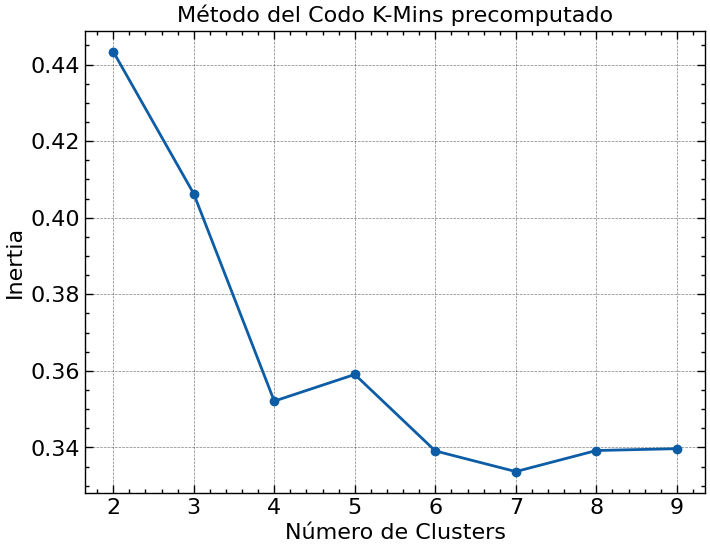

In [24]:
# Reducción de dimensionalidad con PCA
# Reducir los datos escalados a 2 componentes principales para facilitar
# el clustering y la visualización
pca = PCA(n_components=2)
pcaresult = pca.fit_transform(Xscaled)

# Evaluación de diferentes números de clusters
# Se evalúan configuraciones de k=2 hasta k=9 clusters utilizando el
# coeficiente de silueta como métrica de calidad del clustering
inertia = []
valores_k = range(2, 10)

for k in valores_k:
    # Aplicar K-Means con k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pcaresult)

    # Calcular el coeficiente de silueta (valores cercanos a 1 indican mejor separación)
    score = silhouette_score(pcaresult, labels)
    inertia.append(score)

#Visualización del método del codo
# El número óptimo de clusters se identifica donde el coeficiente de silueta
# alcanza su valor máximo o donde la curva muestra un "codo"
plt.plot(valores_k, inertia, marker='o')
plt.title('Método del Codo K-Means precomputado')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silueta')
plt.grid(True, alpha=0.3)
plt.show()

In [25]:
inertia

[np.float64(0.443379392297252),
 np.float64(0.4062478728936074),
 np.float64(0.35207831049496074),
 np.float64(0.35904397638854213),
 np.float64(0.33906787258687676),
 np.float64(0.33367222050015005),
 np.float64(0.3391754286722812),
 np.float64(0.33965620400620317)]

### **APLICAR PCA TENIENDO EN CUENTA RARITY**

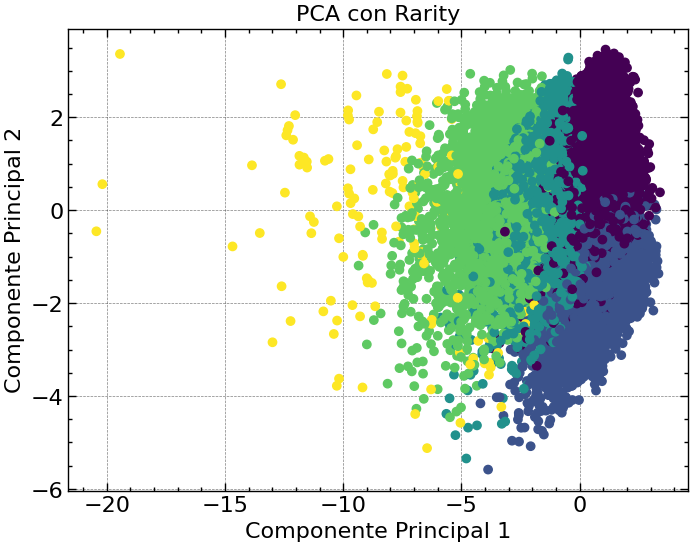

In [26]:
pca = PCA(n_components=2)
pcaresult = pca.fit_transform(Xscaled)

plt.scatter(pcaresult[:, 0], pcaresult[:, 1], c=data['Rarity'])
plt.title('PCA con Rarity')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [27]:
# Agrupar los datos por la columna 'Rarity' (Rareza) y mostrar las estadísticas
# descriptivas para cada nivel de rareza encontrado
for rarity_level in sorted(data['Rarity'].unique()):
    print(f"Descripción del Nivel de Rareza {rarity_level}:")
    display(data[data['Rarity'] == rarity_level].describe())
    print("\n" + "="*50 + "\n")

Rarity Level 0 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster
count,13235,13235.000000,13235.000000,13235.000000,13235.000000,13235.000000,13235.000000,13235.0,13235.000000,13235.000000
mean,1992-03-12 18:53:22.993577600,0.034402,0.029014,8.794655,8.783027,26.116639,0.024499,0.0,1.067095,2.840348
min,1900-01-11 01:07:00,0.020008,0.000000,0.275869,0.125474,24.260000,0.000553,0.0,0.000000,0.000000
25%,1966-12-06 02:02:00,0.026941,0.022023,5.801258,5.787355,25.180000,0.015505,0.0,1.000000,1.000000
50%,2010-10-04 19:50:00,0.034107,0.029310,8.122369,8.111846,25.900000,0.023467,0.0,1.000000,4.000000
75%,2021-01-22 18:22:00,0.041688,0.037842,11.087479,11.080339,26.800000,0.032693,0.0,1.000000,4.000000
max,2026-02-13 14:24:00,0.049996,0.049991,36.372328,36.370672,34.037000,0.049941,0.0,2.000000,4.000000
std,NaN,0.008603,0.011582,4.234692,4.240213,1.275436,0.011634,0.0,0.389178,1.694510




Rarity Level 1 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster
count,10829,10829.000000,10829.000000,10829.000000,10829.000000,10829.000000,10829.000000,10829.0,10829.000000,10829.000000
mean,2008-02-29 04:18:45.167605504,0.009735,0.008808,10.103176,10.027165,27.003167,0.017272,1.0,0.437529,0.682612
min,1900-02-04 06:16:00,0.000044,0.000000,0.650095,0.216022,24.260000,0.000553,1.0,0.000000,0.000000
25%,2009-03-15 10:33:00,0.004668,0.003711,6.766318,6.705507,26.000000,0.009342,1.0,0.000000,0.000000
50%,2019-08-05 08:07:00,0.009561,0.008236,9.300890,9.238895,26.900000,0.014807,1.0,0.000000,0.000000
75%,2023-01-03 05:48:00,0.014704,0.013640,12.703386,12.631767,27.900000,0.022411,1.0,0.000000,2.000000
max,2026-02-13 06:55:00,0.020000,0.019984,39.894881,39.883126,34.037000,0.049941,1.0,2.000000,4.000000
std,NaN,0.005780,0.005708,4.780557,4.790402,1.459608,0.010612,0.0,0.826855,0.960628




Rarity Level 2 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster
count,4509,4509.000000,4509.000000,4509.000000,4509.000000,4509.000000,4509.000000,4509.0,4509.000000,4509.000000
mean,1982-09-23 12:13:01.091150976,0.032137,0.030137,12.177876,12.166869,23.351047,0.079401,2.0,3.346418,1.482369
min,1900-02-04 03:50:00,0.001290,0.000043,1.581997,1.547734,22.030000,0.050172,2.0,0.000000,0.000000
25%,1948-08-29 15:54:00,0.023764,0.020724,8.399688,8.383104,22.820000,0.058947,2.0,4.000000,1.000000
50%,2000-04-26 07:27:00,0.033899,0.031686,11.216480,11.206231,23.470000,0.071856,2.0,4.000000,1.000000
75%,2017-10-04 16:27:00,0.042052,0.040706,14.977864,14.972229,23.900000,0.096931,2.0,4.000000,2.000000
max,2026-02-05 22:48:00,0.050000,0.049997,40.190937,40.186533,24.250000,0.139464,2.0,4.000000,4.000000
std,NaN,0.011956,0.012648,5.317725,5.321900,0.641560,0.024719,0.0,1.267547,0.926281




Rarity Level 3 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster
count,2613,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.0,2613.000000,2613.000000
mean,1967-04-19 04:06:20.642939312,0.033594,0.032989,15.079873,15.072131,20.544845,0.316035,3.0,3.580941,2.165327
min,1900-01-04 22:25:00,0.005019,0.000802,2.712656,2.691730,17.760000,0.140107,3.0,0.000000,1.000000
25%,1934-02-09 08:11:00,0.025546,0.024722,10.118111,10.110796,19.820000,0.182163,3.0,3.000000,1.000000
50%,1968-03-14 19:39:00,0.035500,0.034807,14.029441,14.023221,20.750000,0.251455,3.0,4.000000,3.000000
75%,2002-01-26 15:43:00,0.043374,0.042916,18.889850,18.886931,21.450000,0.385888,3.0,4.000000,3.000000
max,2025-12-15 21:29:00,0.049999,0.049999,40.672808,40.670955,22.020000,0.996463,3.0,4.000000,3.000000
std,NaN,0.011346,0.011654,6.428558,6.431704,1.077818,0.182349,0.0,0.519943,0.972945




Rarity Level 4 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster
count,158,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.0,158.000000,158.000000
mean,1968-05-02 12:54:15.189873312,0.028169,0.027917,17.364521,17.331523,17.496772,1.437335,4.0,3.018987,2.917722
min,1901-04-26 12:50:00,0.000228,0.000228,5.505521,5.494498,14.080000,0.051578,4.0,0.000000,2.000000
25%,1941-02-08 06:56:45,0.015533,0.013947,11.711169,11.700056,16.475000,1.029108,4.0,3.000000,3.000000
50%,1968-01-13 01:44:00,0.032772,0.032002,16.935262,16.930144,17.270000,1.248708,4.0,3.000000,3.000000
75%,2000-05-03 17:20:30,0.042374,0.042037,21.088754,21.065005,17.690000,1.800796,4.0,3.000000,3.000000
max,2024-06-29 13:49:00,0.049959,0.049959,40.509275,40.507937,24.190000,5.425765,4.0,4.000000,3.000000
std,NaN,0.016198,0.016182,7.749057,7.770167,1.797864,0.876430,0.0,0.429361,0.275662


In [36]:
# Crear carpeta para guardar gráficas
output_dir = "pairplots_rarity"
os.makedirs(output_dir, exist_ok=True)

# Obtener niveles de rareza únicos
rarity_levels = sorted(data['Rarity'].unique())
print(f"Total de niveles de rareza encontrados: {len(rarity_levels)}")
print(f"Niveles: {rarity_levels}\n")

for rarity_level in rarity_levels:
    print(f"Generando pair plot para Rarity Level {rarity_level}...")

    # Filtrar datos por nivel de rareza
    rarity_data = data[data['Rarity'] == rarity_level].copy()
    print(f"  Muestras en este nivel: {len(rarity_data)}")

    # Crear pairplot
    g = sns.pairplot(
        data=rarity_data,
        plot_kws={'alpha': 0.6, 's': 15},
        diag_kws={'bins': 25},
        height=2,
        aspect=1
    )

    g.fig.suptitle(f'Pair Plot - Rarity Level {rarity_level}',
                   y=1.00, fontsize=12, fontweight='bold')

    # Ajustar tamaños
    for ax in g.axes.flatten():
        ax.tick_params(labelsize=7)
        ax.xaxis.label.set_size(8)
        ax.yaxis.label.set_size(8)

    plt.tight_layout()

    # Guardar en alta resolución
    filename = f"{output_dir}/rarity_{rarity_level}_pairplot.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"  Guardado: {filename}")

    plt.close()  # Cerrar para liberar memoria
    print("="*60 + "\n")

print(f" Todas las gráficas guardadas en '{output_dir}/'")
print(f" Total de archivos generados: {len(rarity_levels)}")

Total de niveles de rareza encontrados: 5
Niveles: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Generando pair plot para Rarity Level 0...
  Muestras en este nivel: 13235
  ✓ Guardado: pairplots_rarity/rarity_0_pairplot.png

Generando pair plot para Rarity Level 1...
  Muestras en este nivel: 10829
  ✓ Guardado: pairplots_rarity/rarity_1_pairplot.png

Generando pair plot para Rarity Level 2...
  Muestras en este nivel: 4509
  ✓ Guardado: pairplots_rarity/rarity_2_pairplot.png

Generando pair plot para Rarity Level 3...
  Muestras en este nivel: 2613
  ✓ Guardado: pairplots_rarity/rarity_3_pairplot.png

Generando pair plot para Rarity Level 4...
  Muestras en este nivel: 158
  ✓ Guardado: pairplots_rarity/rarity_4_pairplot.png

✓ Todas las gráficas guardadas en 'pairplots_rarity/'
✓ Total de archivos generados: 5


### **APLICANDO T-SNE**

In [29]:
# tsne = TSNE(n_components=2, perplexity=50, random_state=42)
# X_tsne = tsne.fit_transform(Xscaled)

# plt.figure(figsize=(6, 5))
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=1)
# plt.title('t-SNE')
# plt.xlabel('Componente 1')
# plt.ylabel('Componente 2')
# plt.colorbar(label='Cluster')
# plt.show()

In [30]:
!pip install openTSNE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 31.4 MB/s eta 0:00:00


Varianza explicada acumulada PCA : 72.73%
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 31344 samples in 0.015s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 31344 samples in 0.613s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31344
[t-SNE] Computed conditional probabilities for sample 2000 / 31344
[t-SNE] Computed conditional probabilities for sample 3000 / 31344
[t-SNE] Computed conditional probabilities for sample 4000 / 31344
[t-SNE] Computed conditional probabilities for sample 5000 / 31344
[t-SNE] Computed conditional probabilities for sample 6000 / 31344
[t-SNE] Computed conditional probabilities for sample 7000 / 31344
[t-SNE] Computed conditional probabilities for sample 8000 / 31344
[t-SNE] Computed conditional probabilities for sample 9000 / 31344
[t-SNE] Computed conditional probabilities for sample 10000 / 31344
[t-SNE] Computed conditional probabilities for sample 11000 / 31344
[t-SNE] Computed conditional probabilities for sample 12000 / 31344
[t-SNE] Computed conditional probabilities for sample 13000 / 31344
[t-SNE] Computed conditional probabilities for sample 14000 / 31344

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 31344 samples in 0.689s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31344
[t-SNE] Computed conditional probabilities for sample 2000 / 31344
[t-SNE] Computed conditional probabilities for sample 3000 / 31344
[t-SNE] Computed conditional probabilities for sample 4000 / 31344
[t-SNE] Computed conditional probabilities for sample 5000 / 31344
[t-SNE] Computed conditional probabilities for sample 6000 / 31344
[t-SNE] Computed conditional probabilities for sample 7000 / 31344
[t-SNE] Computed conditional probabilities for sample 8000 / 31344
[t-SNE] Computed conditional probabilities for sample 9000 / 31344
[t-SNE] Computed conditional probabilities for sample 10000 / 31344
[t-SNE] Computed conditional probabilities for sample 11000 / 31344
[t-SNE] Computed conditional probabilities for sample 12000 / 31344
[t-SNE] Computed conditional probabilities for sample 13000 / 31344
[t-SNE] Computed conditional probabilities for sample 14000 / 31344

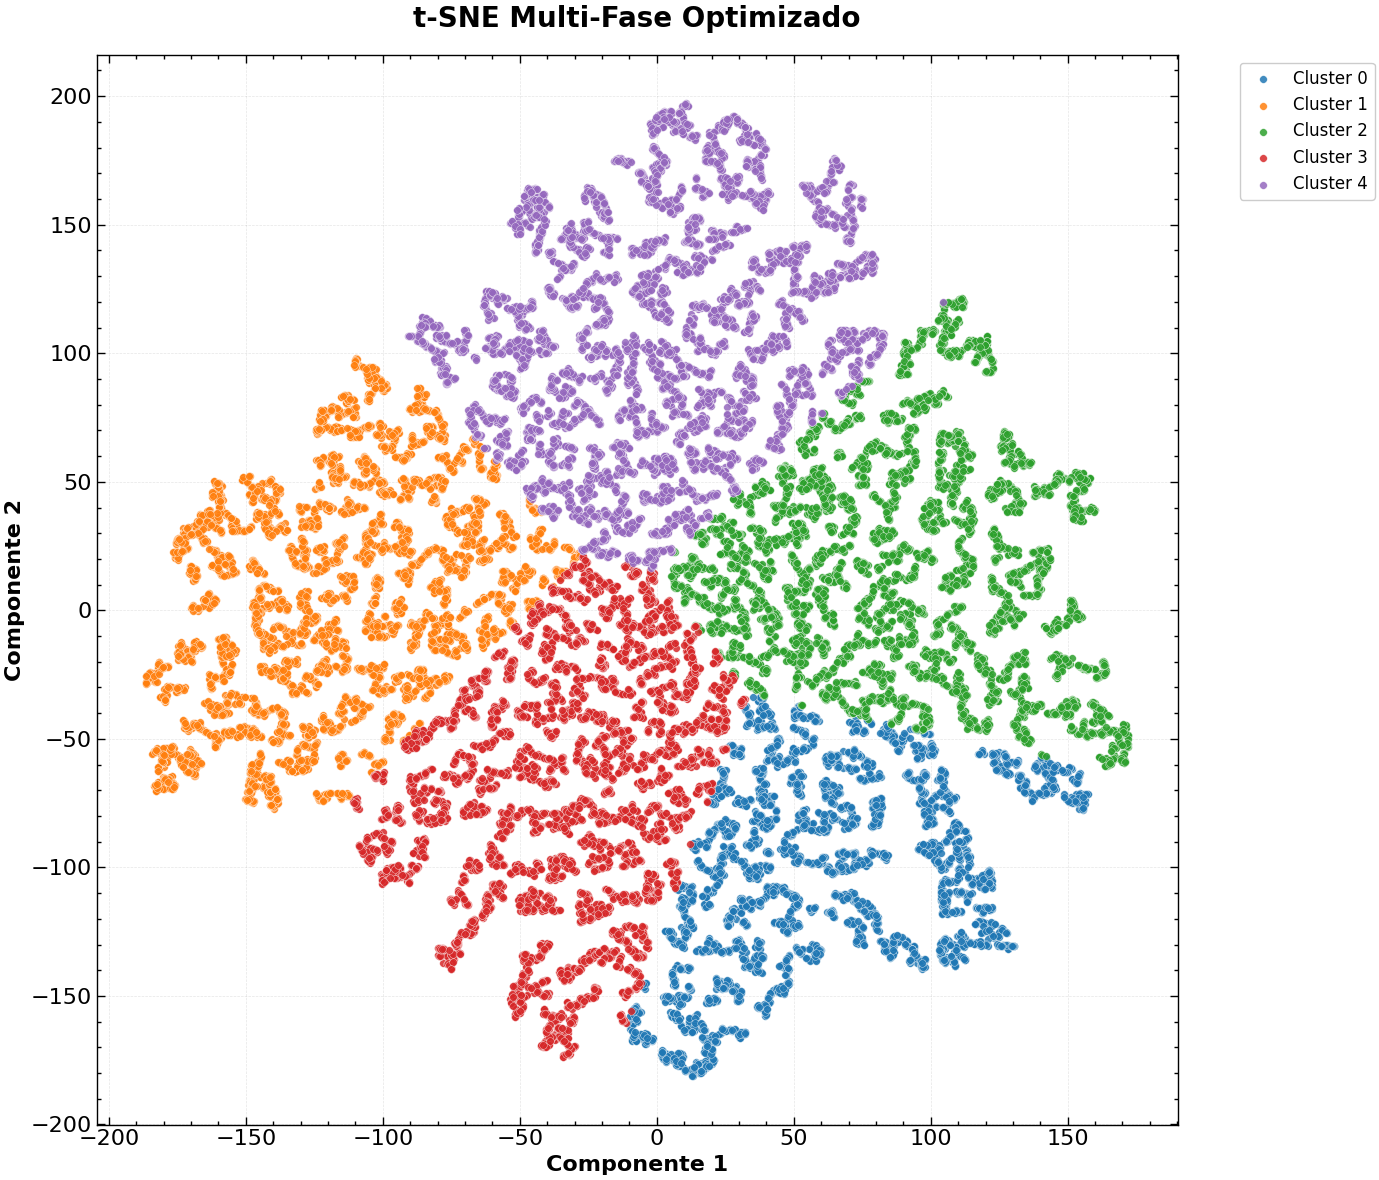

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP Trustworthiness (15 vecinos): 0.7921
UMAP Continuity (15 vecinos): 0.7921


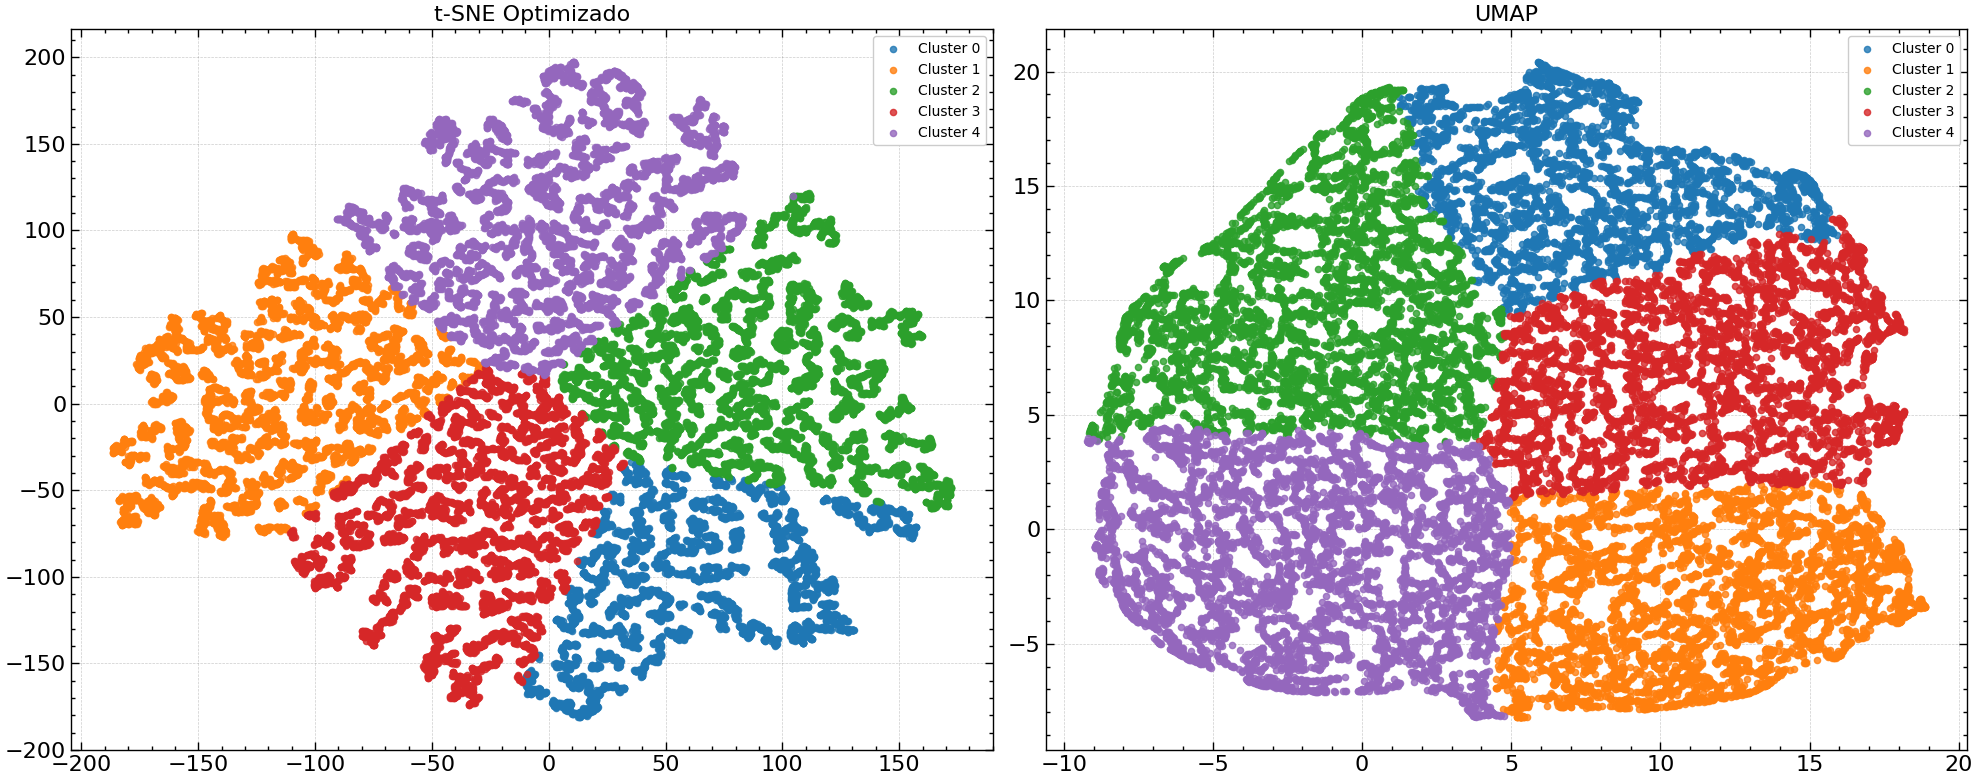

In [32]:
 # Código completo para análisis avanzado y visualización optimizada con t-SNE y UMAP

 from sklearn.decomposition import PCA
 from sklearn.manifold import TSNE
 from sklearn.metrics import pairwise_distances
 from sklearn.neighbors import NearestNeighbors
 from sklearn.preprocessing import StandardScaler

 import umap

# --- Funciones para métricas de calidad t-SNE ---

def trustworthiness(X_high, X_low, n_neighbors=10):
    """
    Trustworthiness mide qué tan bien la estructura local del espacio original
    se preserva en el embedding de baja dimensión.
    """
    n_samples = X_high.shape[0]
    nbrs_high = NearestNeighbors(n_neighbors=n_neighbors).fit(X_high)
    high_dist, high_idx = nbrs_high.kneighbors(X_high)

    nbrs_low = NearestNeighbors(n_neighbors=n_neighbors).fit(X_low)
    low_dist, low_idx = nbrs_low.kneighbors(X_low)

    trust_sum = 0.0
    for i in range(n_samples):
        set_high = set(high_idx[i, 1:])  # vecinos en espacio original (excluye punto mismo)
        set_low = set(low_idx[i, 1:])    # vecinos en embedding
        # vecinos en embedding que no están en original (intrusos)
        intruders = set_low - set_high
        for u in intruders:
            rank = np.where(high_idx[i] == u)[0]
            if len(rank) > 0:
                rank = rank[0]
                trust_sum += rank - n_neighbors
            else:
                trust_sum += n_samples
    trust = 1 - (2 / (n_samples * n_neighbors * (2 * n_samples - 3 * n_neighbors - 1))) * trust_sum
    return trust

def continuity(X_high, X_low, n_neighbors=10):
    """
    Continuity mide qué tan bien los vecinos en el embedding corresponden a vecinos en el espacio original.
    """
    n_samples = X_high.shape[0]
    nbrs_high = NearestNeighbors(n_neighbors=n_neighbors).fit(X_high)
    high_dist, high_idx = nbrs_high.kneighbors(X_high)

    nbrs_low = NearestNeighbors(n_neighbors=n_neighbors).fit(X_low)
    low_dist, low_idx = nbrs_low.kneighbors(X_low)

    cont_sum = 0.0
    for i in range(n_samples):
        set_high = set(high_idx[i, 1:])
        set_low = set(low_idx[i, 1:])
        misses = set_high - set_low
        for m in misses:
            rank = np.where(low_idx[i] == m)[0]
            if len(rank) > 0:
                rank = rank[0]
                cont_sum += rank - n_neighbors
            else:
                cont_sum += n_samples
    cont = 1 - (2 / (n_samples * n_neighbors * (2 * n_samples - 3 * n_neighbors - 1))) * cont_sum
    return cont

# --- Preprocesamiento ---

# Escalado estándar
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)

# PCA previo para reducir ruido y dimensionalidad
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(Xscaled)

print(f"Varianza explicada acumulada PCA : {np.sum(pca.explained_variance_ratio_):.2%}")

# --- t-SNE en dos fases (simulación late exaggeration) ---

tsne_phase1 = TSNE(
    n_components=2,
    perplexity=25,
    early_exaggeration=40,
    learning_rate=1000,
    n_iter=1000,
    random_state=42,
    init='pca',
    verbose=1
)
X_tsne_phase1 = tsne_phase1.fit_transform(X_pca)

tsne_phase2 = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=25,
    learning_rate=500,
    n_iter=1500,
    random_state=42,
    init=X_tsne_phase1,
    verbose=1
)
X_tsne_refined = tsne_phase2.fit_transform(X_pca)

# --- Cálculo métricas de calidad ---

trust = trustworthiness(X_pca, X_tsne_refined, n_neighbors=15)
cont = continuity(X_pca, X_tsne_refined, n_neighbors=15)

print(f"Trustworthiness (15 vecinos): {trust:.4f}")
print(f"Continuity (15 vecinos): {cont:.4f}")

# --- Visualización t-SNE optimizado ---

# Aplicar el algoritmo K-Means a los datos refinados de t-SNE para identificar 5 clusters
# Se utiliza random_state=42 para reproducibilidad y n_init='auto' para optimización automática
kmeans_tsne = KMeans(n_clusters=5, random_state=42, n_init='auto')
data['tSNE_Cluster'] = kmeans_tsne.fit_predict(X_tsne_refined)

# Visualización de los clusters en el espacio t-SNE
plt.figure(figsize=(14, 12))
palette = sns.color_palette("tab10", n_colors=len(np.unique(data['tSNE_Cluster'])))

# Graficar cada cluster con un color diferente
for i, cluster in enumerate(np.unique(data['tSNE_Cluster'])):
    mask = data['tSNE_Cluster'] == cluster
    plt.scatter(
        X_tsne_refined[mask, 0], X_tsne_refined[mask, 1],
        c=[palette[i]],
        label=f'Cluster {cluster}',
        s=30,
        alpha=0.85,
        edgecolors='white',
        linewidth=0.3
    )
plt.title('t-SNE Multi-Fase Optimizado', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Componente 1', fontsize=16, fontweight='bold')
plt.ylabel('Componente 2', fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

# --- Aplicación y visualización con UMAP para comparación ---

umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)
X_umap = umap_reducer.fit_transform(X_pca)

# Métricas UMAP
trust_umap = trustworthiness(X_pca, X_umap, n_neighbors=15)
cont_umap = continuity(X_pca, X_umap, n_neighbors=15)

print(f"UMAP Trustworthiness (15 vecinos): {trust_umap:.4f}")
print(f"UMAP Continuity (15 vecinos): {cont_umap:.4f}")

# Visualización comparativa lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for i, cluster in enumerate(np.unique(data['tSNE_Cluster'])):
    mask = data['tSNE_Cluster'] == cluster
    ax1.scatter(
        X_tsne_refined[mask, 0], X_tsne_refined[mask, 1],
        c=[palette[i]], s=20, alpha=0.8, label=f'Cluster {cluster}'
    )
ax1.set_title('t-SNE Optimizado')
ax1.grid(True, alpha=0.2)
ax1.legend(fontsize=10)

for i, cluster in enumerate(np.unique(data['tSNE_Cluster'])):
    mask = data['tSNE_Cluster'] == cluster
    ax2.scatter(
        X_umap[mask, 0], X_umap[mask, 1],
        c=[palette[i]], s=20, alpha=0.8, label=f'Cluster {cluster}'
    )
ax2.set_title('UMAP')
ax2.grid(True, alpha=0.2)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [33]:
# Crear carpeta para guardar gráficas
output_dir = "pairplots_clusters"
os.makedirs(output_dir, exist_ok=True)

for cluster_id in sorted(data['tSNE_Cluster'].unique()):
    print(f"Generando pair plot para Cluster {cluster_id}...")

    g = sns.pairplot(
        data=data[data['tSNE_Cluster'] == cluster_id].copy(),
        plot_kws={'alpha': 0.6, 's': 15},
        diag_kws={'bins': 25},
        height=2,
        aspect=1
    )

    g.fig.suptitle(f'Pair Plot - Cluster {cluster_id}',
                   y=1.00, fontsize=12, fontweight='bold')

    # Ajustar tamaños
    for ax in g.axes.flatten():
        ax.tick_params(labelsize=7)
        ax.xaxis.label.set_size(8)
        ax.yaxis.label.set_size(8)

    plt.tight_layout()

    # Guardar en alta resolución
    filename = f"{output_dir}/cluster_{cluster_id}_pairplot.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f" Guardado: {filename}")

    plt.close()  # Cerrar para liberar memoria

print(f"\n Todas las gráficas guardadas en '{output_dir}/'")

Generando pair plot para Cluster 0...
 Guardado: pairplots_clusters/cluster_0_pairplot.png
Generando pair plot para Cluster 1...
 Guardado: pairplots_clusters/cluster_1_pairplot.png
Generando pair plot para Cluster 2...
 Guardado: pairplots_clusters/cluster_2_pairplot.png
Generando pair plot para Cluster 3...
 Guardado: pairplots_clusters/cluster_3_pairplot.png
Generando pair plot para Cluster 4...
 Guardado: pairplots_clusters/cluster_4_pairplot.png

 Todas las gráficas guardadas en 'pairplots_clusters/'


In [35]:
# Añadir las etiquetas de cluster obtenidas al dataframe original
# como una nueva columna llamada 'tSNE_Cluster'
data['tSNE_Cluster'] = clusters

# Agrupar los datos por la columna 'tSNE_Cluster' y mostrar las estadísticas
# descriptivas para cada cluster identificado
for cluster_id in sorted(data['tSNE_Cluster'].unique()):
    print(f"Descripción del Cluster {cluster_id}:")
    display(data[data['tSNE_Cluster'] == cluster_id].describe())
    print("\n" + "="*50 + "\n")

Cluster 0 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster,tSNE_Cluster
count,10019,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.0,10019.0
mean,2000-07-05 22:04:21.882423552,0.014928,0.011040,8.063928,8.002794,27.025737,0.017302,0.740693,0.256014,0.0,0.0
min,1900-01-25 06:22:00,0.000044,0.000000,0.650095,0.216022,22.370000,0.000553,0.000000,0.000000,0.0,0.0
25%,1984-09-12 10:53:00,0.007454,0.004894,6.172072,6.117300,26.020000,0.009342,0.000000,0.000000,0.0,0.0
50%,2017-02-26 03:50:00,0.014306,0.010623,8.133963,8.074339,26.920000,0.014671,1.000000,0.000000,0.0,0.0
75%,2022-04-17 13:59:00,0.020725,0.016569,9.958726,9.910660,27.900000,0.022206,1.000000,0.000000,0.0,0.0
max,2026-02-13 06:55:00,0.049983,0.031624,18.834843,18.831358,34.037000,0.119251,2.000000,2.000000,0.0,0.0
std,NaN,0.009494,0.007017,2.705532,2.725671,1.488389,0.011556,0.466519,0.523583,0.0,0.0




Cluster 1 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster,tSNE_Cluster
count,5164,5164.000000,5164.000000,5164.000000,5164.000000,5164.000000,5164.000000,5164.000000,5164.000000,5164.0,5164.0
mean,1984-02-06 18:00:38.749031744,0.036720,0.034937,12.131608,12.124346,23.197789,0.104286,1.777692,3.421766,1.0,1.0
min,1900-01-04 22:25:00,0.009028,0.000930,2.712656,2.691730,18.750000,0.007120,0.000000,0.000000,1.0,1.0
25%,1950-03-01 20:16:45,0.030693,0.028837,9.067142,9.059575,22.260000,0.052055,2.000000,4.000000,1.0,1.0
50%,2001-12-13 05:04:30,0.037320,0.035516,12.153347,12.148502,23.390000,0.074552,2.000000,4.000000,1.0,1.0
75%,2018-10-28 00:35:30,0.043877,0.042465,14.695249,14.691244,24.170000,0.125447,2.000000,4.000000,1.0,1.0
max,2026-02-05 00:25:00,0.049999,0.049999,26.929582,26.926810,28.490000,0.631627,3.000000,4.000000,1.0,1.0
std,NaN,0.008522,0.009305,3.809537,3.812222,1.476553,0.085884,1.004425,1.086015,0.0,0.0




Cluster 2 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster,tSNE_Cluster
count,5038,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.0,5038.0
mean,2005-02-20 19:02:53.175863552,0.011411,0.009380,15.346833,15.292918,25.957962,0.031922,1.074633,1.466455,2.0,2.0
min,1900-02-27 07:57:00,0.000045,0.000000,6.237726,6.143385,20.160000,0.000814,0.000000,0.000000,2.0,2.0
25%,2006-09-02 08:44:00,0.004723,0.003623,12.580162,12.527107,24.800000,0.013504,1.000000,0.000000,2.0,2.0
50%,2018-10-17 14:22:00,0.010085,0.008116,14.564133,14.509299,26.000000,0.022411,1.000000,2.000000,2.0,2.0
75%,2022-10-29 13:58:30,0.016404,0.014188,17.551162,17.490692,27.100000,0.038946,1.000000,2.000000,2.0,2.0
max,2026-02-12 10:58:00,0.049614,0.033195,39.894881,39.883126,33.200000,0.329960,4.000000,4.000000,2.0,2.0
std,NaN,0.008371,0.006724,3.999899,4.007150,1.788873,0.030657,0.579228,1.042080,0.0,0.0




Cluster 3 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster,tSNE_Cluster
count,1945,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.0,1945.0
mean,1971-03-13 11:01:44.791773824,0.033739,0.032988,19.815003,19.809384,20.420121,0.417901,2.900771,3.161954,3.0,3.0
min,1900-02-05 23:42:00,0.000503,0.000499,5.505521,5.494498,14.080000,0.021700,0.000000,2.000000,3.0,3.0
25%,1936-11-21 14:15:00,0.025569,0.024588,15.701750,15.693148,19.280000,0.172370,3.000000,3.000000,3.0,3.0
50%,1975-09-14 16:36:00,0.035778,0.034823,19.319764,19.316907,20.470000,0.286063,3.000000,3.000000,3.0,3.0
75%,2008-04-17 02:46:00,0.043298,0.042732,23.546157,23.543400,21.570000,0.494836,3.000000,4.000000,3.0,3.0
max,2026-01-26 10:48:00,0.050000,0.049993,40.672808,40.670955,26.070000,5.425765,4.000000,4.000000,3.0,3.0
std,NaN,0.011281,0.011600,6.085385,6.087003,1.795913,0.444634,0.526973,0.600919,0.0,0.0




Cluster 4 Description:


,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity,Cluster,KMeans_PCA_Cluster,tSNE_Cluster
count,9178,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.00000,9178.000000,9178.0,9178.0
mean,1991-09-15 09:58:32.569187200,0.036561,0.033063,6.925720,6.912696,26.013452,0.025788,0.07202,1.090761,4.0,4.0
min,1900-01-11 01:07:00,0.016145,0.000136,0.275869,0.125474,22.320000,0.001015,0.00000,0.000000,4.0,4.0
25%,1966-03-01 23:58:00,0.030152,0.026793,4.912870,4.895277,25.120000,0.016086,0.00000,1.000000,4.0,4.0
50%,2009-09-21 18:43:00,0.036853,0.032953,6.826483,6.818078,25.880000,0.023684,0.00000,1.000000,4.0,4.0
75%,2020-11-12 08:57:15,0.043156,0.040070,8.813781,8.806779,26.720000,0.033609,0.00000,1.000000,4.0,4.0
max,2026-02-13 14:24:00,0.049996,0.049975,15.579065,15.575472,32.720000,0.122028,2.00000,4.000000,4.0,4.0
std,NaN,0.007889,0.008995,2.689084,2.696186,1.252549,0.013440,0.36809,0.536699,0.0,0.0
